## Hierarchical modeling of mutual inclinations

Here's what seems like a pretty straightforward question. Let's say we have measurements of the inclination of a binary star orbit and its circumbinary disk relative to the sky plane, $i_\mathrm{disk}$ and $i_\star$. And, let's say that these are pretty similar, like $i_\mathrm{disk} = 33.5^\circ \pm 1.4^\circ$ and $i_\star = 33.42^\circ \pm 0.01^\circ$. How misaligned are these two planes, i.e, what's the mutual inclination? You might say the fact that
$$
|i_\mathrm{disk} - i_\star| = |33.5^\circ - 33.42^\circ| < 0.1^\circ
$$
means that these planes are pretty much coplanar. However, that's not the full story because $i$ just tells us the inclination of each orbit relative to the sky plane---we need to know the position angle of the ascending node $\Omega$ to actually orient each orbit in 3D space. Given both of these measurements for both the binary star orbit and its circumbinary disk, we can calucate the mutual inclination $\Delta I$ between the two as

$$
\cos (\Delta I) = \cos i_\mathrm{disk} \cos i_\star + \sin i_\mathrm{disk} \sin i_\star \cos(\Omega_\mathrm{disk} - \Omega_\star).
$$
For the subset of systems that have protoplanetary disk-based solutions and double-lined radial velocity solutions, we generally have precise constraints on $i_\mathrm{disk}$, $\Omega_\mathrm{disk}$, and $i_\star$, but no constraint on $\Omega_\star$ and therefore we are unable to directly solve for $\imut$. For the disk example, we measured $\Omega_\mathrm{disk} = 256^\circ \pm 1.0^\circ$.

The goal then, is to use the measurements of these three parameters to determine the posterior propbability distribution of the mutual inclination. For an isotropically oriented orbit in 3D space, the prior probability distribution on the pair of parameters is
$$
p(i, \Omega) = \frac{\sin i}{2}.
$$

Let $\boldsymbol{\theta} = \{i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star \}$ and $\boldsymbol{d} = \{ \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} \}$ be the measured values of these parameters and $\boldsymbol{\Sigma}$ be the covariances of them. Then, assuming a uniform prior $\Omega_\star$ we can go through the process of translating the measurements into a constraint on $\Delta I$.

Here we'll add in some short notes and example code about getting the answer that points to a large bias in the parameters. 

In [43]:
# code here
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

import numpy as np
import theano.tensor as tt
import pymc3 as pm

import matplotlib.pyplot as plt

deg = np.pi/180.0

For any one disk, this result makes sense. Without a measurement of $\Omega_\star$, we can't actually say what the mutual inclination is, other than an upper limit. 

While such a conclusion is perhaps inevitiable for one disk, there arrises a paradox when we consider a collection of disks. Let's say we had a sample of 5 disks, and they all had $i_\mathrm{disk} \approx i_\star$. We would suspect that there is some sort of alignment in 3D space, because if there wasn't, we would have seen at least a few disks with $i_\mathrm{disk} \ne i_\star$ in this sample. 

The reason this occurs is because the maximum likelihood estimator for $\Delta I$ is biased. One way around this is to consider a hierarchical Bayesian model for the population of 5 disks, where we seek to infer the distribution function of mutual inclinations.

# Hierarchical modeling 


Let's assume some functional form for our mutual inclination distribution. Possible distributions include the [beta](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Beta), the [Weibull](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Weibull), and the [gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma).

Eugene pointed out that a desirable quality of this distribution is that (regardless of whether mutual inclinations are in general low or high) it obeys

$$
\lim_{\Delta I \to 0} p(\imut) = 0
$$

The reason why is analogous to pointing a telescope at a target at $(\alpha, \delta)$. There will always be some (small) pointing error, and we actually point at $(\alpha + \epsilon_\alpha, \delta + \epsilon_\delta)$. This means that there will *always* be some positive radial pointing error, and so there should be 0 probability that we point exactly at $(\alpha, \delta)$. The same thing goes for pointing exactly opposite

$$
\lim_{\Delta I \to 180^\circ} p(\imut) = 0
$$


We still need to look a little bit at these distributions and whether we can enforce this behavior just by setting priors on their hyperparameters, or whether we should look at designing our own custom distribution, something like $\sin(\Delta I) \beta$ or whatever. If we do need to do this, it shouldn't be [too hard to do](https://docs.pymc.io/Probability_Distributions.html) in PyMC3/Theano.

Let's start with the $\beta$ distribution. The PDF is 

$$
p(x |\, \alpha, \beta) = \frac{x^{\alpha - 1}(1 - x)^{\beta - 1}}{B(\alpha, \beta)}
$$
where
$$
B(\alpha, \beta) = \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha + \beta)}
$$
From the PDF, we see that if we enforce a prior that $\alpha > 1$ and $\beta > 1$, then this will give us the behavior we want. As an example, here are a range of $\beta$ functions for a range of $\alpha$ and $\beta$ values. 

In [23]:
import itertools

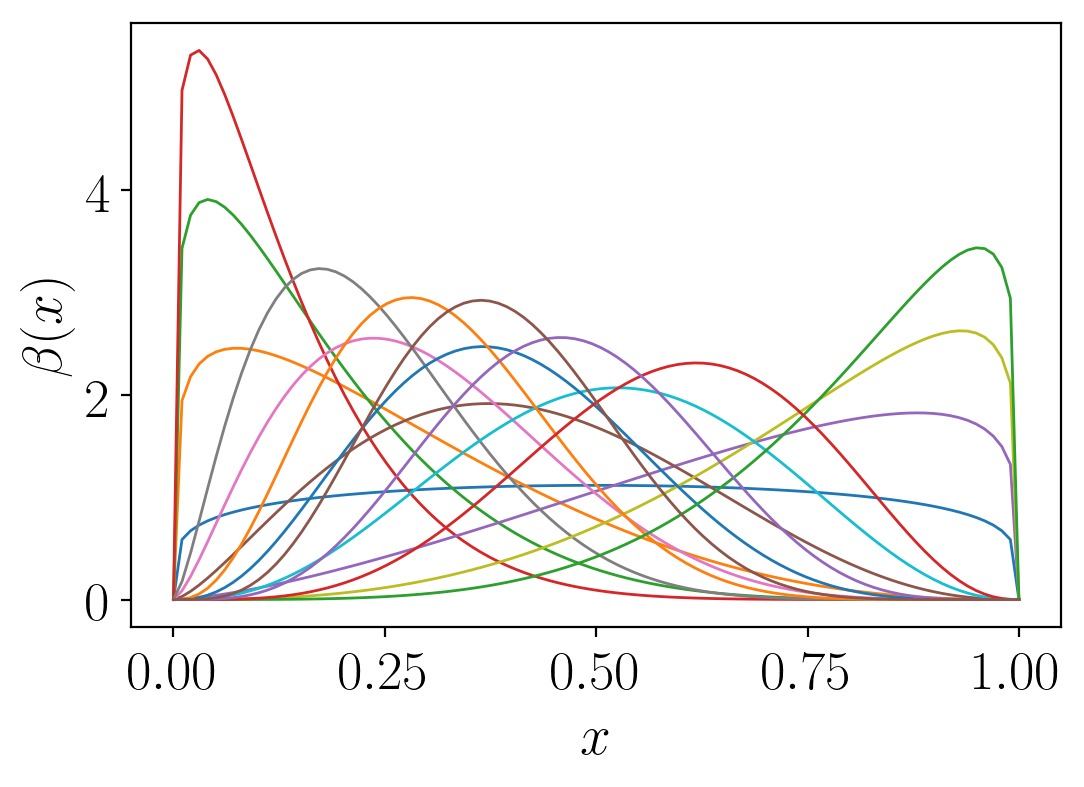

In [69]:
alphas = np.linspace(1.2, 5.0, num=4)
betas = np.linspace(1.2, 8.0, num=4)

xs = np.linspace(0, 1, num=100) # inputs 

fig, ax = plt.subplots(nrows=1)

for alpha,beta in itertools.product(alphas, betas): # plot all combinations
    y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
    ys = np.exp(np.array([y.logp(x).eval() for x in xs]))
    ax.plot(xs, ys, lw=1.0)
    
ax.set_xlabel(r"$x$");
ax.set_ylabel(r"$\beta(x)$");

## Setting up the hierarchical model 

First, we'll need to transform the variable $\Delta I$ into something that fits the range $[0, 1]$. The true domain of $\imut$ is [0,180]. We can try using the variable $\cos\imut$, which ranges from $[-1, 1]$. 

Let's try
$$
\xi = 0.5 (1 - \cos \Delta I)
$$
which now makes $\xi = 0$ be completely aligned and $\xi = 1$ be completely anti-aligned.

We also need to conserve probability such that
$$
p(\xi)\,\mathrm{d}\xi = p(\Delta I)\,\mathrm{d} \Delta I
$$
where
$$
\mathrm{d}\xi = -0.5 \sin(\Delta I)\,\mathrm{d}\Delta I
$$

We'll say that the modified mutual inclination $\xi$ for any particular system is drawn from the distribution of mutual inclinations 
$$
\xi \sim \beta(\alpha, \beta)
$$

So therefore that any fit of the orbital parameters of system $k$ are determined with this prior in place
$$
p_k(\xi_k) = \beta(\xi_k | \alpha, \beta)
$$
which, in the space of mutual inclinations means that 
$$
p_k(\Delta I) = p_k(\xi_k) \frac{\mathrm{d}\xi}{\mathrm{d}\Delta I} = 0.5 \beta(0.5(1 - \cos \Delta I) | \alpha, \beta) \sin(\Delta I)
$$

**Insert likelihood for fitting individual model here**

To get started, we'll try out this formalism on at least two different fake datasets. The first will have mutual inclinations drawn from a nearly coplanar distribution. We'll assume the disk parameters are measured, then we will chose the binary parameters such that they satisfy the the mutual inclination constraint, I think first by choosing $\Omega_\star$ randomly from $[0, 360]$ and then calculating $i_\star$. For this first pass through, we'll assume that we've precisely measured the disk parameters, and so $i_\mathrm{disk}$ and $\Omega_\mathrm{disk}$ are exactly known. We'll revisit this later allowing for uncertainties in these parameters.

The second will have mutual inclinations drawn from an isotropic distribution in 3D space.

Then, we will apply our hierarchical Bayesian framework to infer the probability distribution.


In [44]:
np.random.seed(42)
N_systems = 5

# let's get a sample of uniformly oriented disks in 3D space 
# Generate randomly oriented momentum vector on the sky.
U = np.random.uniform(size=N_systems)
V = np.random.uniform(size=N_systems)

# spherical coordinates for angular momentum vector, uniformly distributed.
Omega_disk = 2 * np.pi * U / deg # azimuth
i_disk = np.arccos(2 * V - 1.0) / deg # polar angle

In [60]:
for pair in zip(i_disk, Omega_disk):
    print("i_disk: {:>6.2f} deg, Omega_disk: {:>6.2f} deg".format(*pair))

i_disk: 133.47 deg, Omega_disk: 134.83 deg
i_disk: 152.11 deg, Omega_disk: 342.26 deg
i_disk:  42.92 deg, Omega_disk: 263.52 deg
i_disk:  78.33 deg, Omega_disk: 215.52 deg
i_disk:  65.41 deg, Omega_disk:  56.17 deg


Now, let's choose our two distributions on $\Delta I$. The one with close alignments

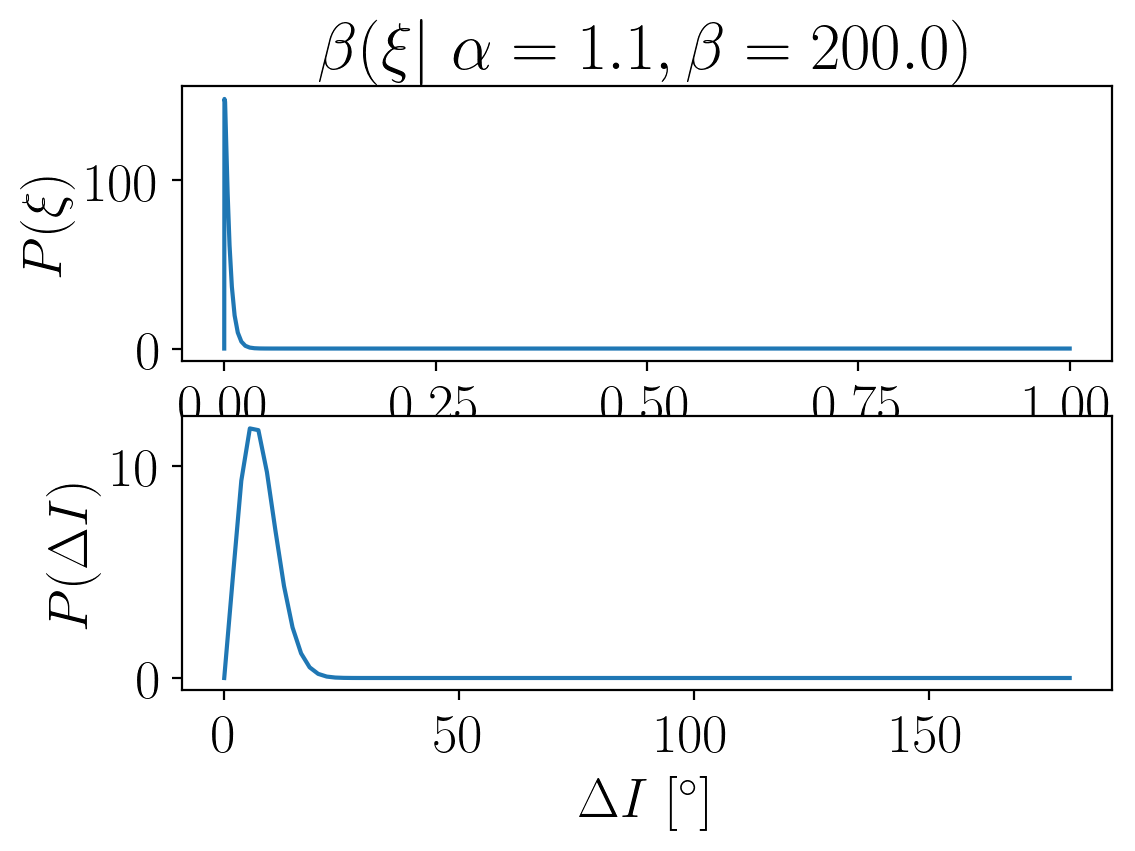

In [79]:
DeltaIs = np.linspace(0.0, 180.0, num=100) # inputs 
xis = 0.5 * (1 - np.cos(DeltaIs * deg))

fig, ax = plt.subplots(nrows=2)

alpha = 1.1
beta = 200.0
y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
ys = np.exp(np.array([y.logp(xi).eval() for xi in xis]))
ax[0].plot(xis, ys)
    
PIs = ys * np.sin(DeltaIs * deg)
ax[1].plot(DeltaIs, PIs)    
    
ax[0].set_xlabel(r"$\xi$");
ax[0].set_ylabel(r"$P(\xi)$");
ax[0].set_title(r"$\beta(\xi |\ \alpha={:.1f}, \beta={:.1f})$".format(alpha, beta));

ax[1].set_ylabel(r"$P(\Delta I)$");
ax[1].set_xlabel(r"$\Delta I$ [${}^\circ$]");

The conversions between the two variables are
$$
\xi = 0.5 (1 - \cos \Delta I)
$$

$$
\Delta I = \cos^{-1}(1 - 2 \xi)
$$
The $\beta$ distribution does OK for this, but I guess I'd like something a bit stronger at lower mutual inclinations and a bit softer at larger mutual inclinations. Anyway, it's probably an OK start to the problem for now.

In [80]:
# let's actually draw from samples from this 
alpha = 1.1
beta = 200.0
y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation

xis = y.random(size=N_systems)
DeltaIs = np.arccos(1 - 2 * xis)/deg    

for pair in zip(xis, DeltaIs):
    print(pair)
    
# Now, assume that the direction of this offset from the vector position of the disk 
# is randomly chosen from 0,360 on the unit sphere
# apply this Delta I offset from this point
# then 

(0.002043184221581926, 5.181486758714563)
(0.00571201449847902, 8.66885216413623)
(0.0008703620281001284, 3.3811591616826626)
(0.014540156307254826, 13.851451118134559)
(0.0018944931765767406, 4.989262730358599)


In [ ]:
# can we also take into account that there are possibly retrograde orbits?